In [1]:
import scipy.io as sio
data = sio.loadmat('URpickNplace.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb 26 20:08:47 2015',
 '__version__': '1.0',
 '__globals__': [],
 'urPicknPlace': array([[ 0.0202, -1.5547, -0.0255, ...,  0.4891, -1.8791, -0.1669],
        [ 0.0202, -1.5547, -0.0255, ...,  0.4333, -1.7954, -0.1669],
        [ 0.0202, -1.5547, -0.0255, ...,  0.3775, -1.8512, -0.0279],
        ...,
        [ 0.0202, -1.5547, -0.0255, ...,  0.3217, -1.907 , -0.1948],
        [ 0.0202, -1.5547, -0.0255, ...,  0.21  , -1.907 , -0.1948],
        [ 0.0202, -1.5547, -0.0255, ...,  0.2658, -1.8512, -0.1948]]),
 'urPicknPlaceHyper': array([[-3.05840e+00, -2.33240e+00, -1.47950e+00, ...,  1.19303e+01,
         -3.11790e+00, -4.72900e-01],
        [-1.00000e-04, -1.57080e+00,  0.00000e+00, ...,  2.70710e+00,
          2.62200e+00,  2.75380e+00],
        [ 2.02000e-02, -1.55470e+00, -2.55000e-02, ...,  4.61200e-01,
         -1.85120e+00, -2.22600e-01],
        ...,
        [-2.55260e+00, -1.89180e+00, -3.60300e-01, ..., -9

In [127]:
import numpy as np

# Assuming you have loaded your dataset into the 'data' variable

# Get the dimensions of the input array 'urPicknPlace'
input_array_shape = data['urPicknPlace'].shape

# Get the dimensions of the output array 'urPicknPlaceHyper'
output_array_shape = data['urPicknPlaceHyper'].shape

print("Input array shape:", input_array_shape)
print("Output array shape:", output_array_shape)


Input array shape: (12349, 24)
Output array shape: (2000, 24)


In [142]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# Assuming you have loaded your dataset into the 'data' variable
input_data = data['urPicknPlace']
output_data = data['urPicknPlaceHyper']

# Convert the data to PyTorch tensors
X = torch.tensor(input_data, dtype=torch.float32)
Y = torch.tensor(output_data, dtype=torch.float32)
# Normalize the input data
X_mean = X.mean(dim=0)
X_std = X.std(dim=0)
X = (X - X_mean) / X_std
# Check the shapes of the tensors
print("Input tensor shape:", X.shape)
print("Output tensor shape:", Y.shape)

Input tensor shape: torch.Size([12349, 24])
Output tensor shape: torch.Size([2000, 24])


In [167]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Shuffle the data indices for X
indices_X = torch.randperm(X.shape[0])

# Select a subset of X that matches the size of Y
X_subset = X[indices_X[:Y.shape[0]]]

# Shuffle the data indices for Y
indices_Y = torch.randperm(Y.shape[0])

# Split the data for X and Y
train_size = int(0.6 * Y.shape[0])
val_size = int(0.2 * Y.shape[0])
test_size = Y.shape[0] - train_size - val_size

X_train = X_subset[indices_Y[:train_size]]
X_val = X_subset[indices_Y[train_size: train_size + val_size]]
X_test = X_subset[indices_Y[train_size + val_size:]]

Y_train = Y[indices_Y[:train_size]]
Y_val = Y[indices_Y[train_size: train_size + val_size]]
Y_test = Y[indices_Y[train_size + val_size:]]

# Print the shapes of the datasets to verify
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([1200, 24])
X_val shape: torch.Size([400, 24])
X_test shape: torch.Size([400, 24])
Y_train shape: torch.Size([1200, 24])
Y_val shape: torch.Size([400, 24])
Y_test shape: torch.Size([400, 24])


In [133]:
# Define your data augmentation transformations
def random_horizontal_flip(tensor, p=0.5):
    if torch.rand(1) < p:
        return torch.flip(tensor, dims=[-1])
    return tensor

def random_vertical_flip(tensor, p=0.5):
    if torch.rand(1) < p:
        return torch.flip(tensor, dims=[-2])
    return tensor

def random_rotation(tensor, degrees=10):
    angle = torch.randint(-degrees, degrees, (1,))
    return torch.rot90(tensor, k=angle.item(), dims=[-1, -2])

def random_color_jitter(tensor, brightness=0.2, contrast=0.2, saturation=0.2):
    tensor = tensor + torch.randn_like(tensor) * brightness
    tensor = torch.clamp(tensor, 0.0, 1.0)
    tensor_mean = tensor.mean(dim=[-1, -2], keepdim=True)
    tensor = (tensor - tensor_mean) * (1.0 + torch.randn_like(tensor) * contrast) + tensor_mean
    tensor = torch.clamp(tensor, 0.0, 1.0)
    return tensor

# Create data loaders with data augmentation for the training set
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = AugmentedDataset(X_train, Y_train, transform=random_horizontal_flip)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a validation data loader without data augmentation
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [144]:
import torch.nn as nn

class DeterministicModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeterministicModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16,16)
        self.fc3 = nn.Linear(16, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [135]:
# Create the deterministic model
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
deterministic_model = DeterministicModel(input_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(deterministic_model.parameters(), lr=0.0001)


In [120]:
# Training loop with data augmentation
num_epochs = 20

for epoch in range(num_epochs):
    # Training
    deterministic_model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = deterministic_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    deterministic_model.eval()
    with torch.no_grad():
        total_val_loss = 0

        for inputs, targets in val_loader:
            val_outputs = deterministic_model(inputs)
            val_loss = criterion(val_outputs, targets)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 0/20, Train Loss: 45.6102, Val Loss: 36.9156
Epoch 1/20, Train Loss: 45.7345, Val Loss: 36.8130
Epoch 2/20, Train Loss: 45.5502, Val Loss: 36.6977
Epoch 3/20, Train Loss: 45.4752, Val Loss: 36.6131
Epoch 4/20, Train Loss: 45.0891, Val Loss: 36.5074
Epoch 5/20, Train Loss: 45.2125, Val Loss: 36.4252
Epoch 6/20, Train Loss: 45.0340, Val Loss: 36.3380
Epoch 7/20, Train Loss: 44.8547, Val Loss: 36.2309
Epoch 8/20, Train Loss: 45.1077, Val Loss: 36.1501
Epoch 9/20, Train Loss: 44.9578, Val Loss: 36.0925
Epoch 10/20, Train Loss: 44.7161, Val Loss: 36.0033
Epoch 11/20, Train Loss: 44.9110, Val Loss: 35.9291
Epoch 12/20, Train Loss: 44.6639, Val Loss: 35.8698
Epoch 13/20, Train Loss: 44.5645, Val Loss: 35.7780
Epoch 14/20, Train Loss: 44.3853, Val Loss: 35.7069
Epoch 15/20, Train Loss: 44.5152, Val Loss: 35.6237
Epoch 16/20, Train Loss: 44.3640, Val Loss: 35.5465
Epoch 17/20, Train Loss: 44.1019, Val Loss: 35.4795
Epoch 18/20, Train Loss: 44.2202, Val Loss: 35.4131
Epoch 19/20, Train Los

In [122]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    deterministic_model.train()
    optimizer.zero_grad()
    outputs = deterministic_model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    deterministic_model.eval()
    with torch.no_grad():
        val_outputs = deterministic_model(X_val)  # Use X_val and Y_val directly for validation
        val_loss = criterion(val_outputs, Y_val)
        val_losses.append(val_loss.item())
        
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch 0/100, Train Loss: 44.1163, Val Loss: 37.0808
Epoch 1/100, Train Loss: 44.1127, Val Loss: 37.0821
Epoch 2/100, Train Loss: 44.1090, Val Loss: 37.0825
Epoch 3/100, Train Loss: 44.1052, Val Loss: 37.0820
Epoch 4/100, Train Loss: 44.1013, Val Loss: 37.0809
Epoch 5/100, Train Loss: 44.0973, Val Loss: 37.0793
Epoch 6/100, Train Loss: 44.0933, Val Loss: 37.0771
Epoch 7/100, Train Loss: 44.0892, Val Loss: 37.0746
Epoch 8/100, Train Loss: 44.0850, Val Loss: 37.0718
Epoch 9/100, Train Loss: 44.0808, Val Loss: 37.0688
Epoch 10/100, Train Loss: 44.0766, Val Loss: 37.0655
Epoch 11/100, Train Loss: 44.0724, Val Loss: 37.0621
Epoch 12/100, Train Loss: 44.0681, Val Loss: 37.0586
Epoch 13/100, Train Loss: 44.0637, Val Loss: 37.0550
Epoch 14/100, Train Loss: 44.0594, Val Loss: 37.0513
Epoch 15/100, Train Loss: 44.0550, Val Loss: 37.0477
Epoch 16/100, Train Loss: 44.0506, Val Loss: 37.0440
Epoch 17/100, Train Loss: 44.0462, Val Loss: 37.0403
Epoch 18/100, Train Loss: 44.0418, Val Loss: 37.0366
Epo

Training with batch size: 16
Epoch 0/100, Train Loss: 45.5840, Val Loss: 38.4862
Epoch 1/100, Train Loss: 45.3799, Val Loss: 38.2759
Epoch 2/100, Train Loss: 45.1901, Val Loss: 38.0551
Epoch 3/100, Train Loss: 44.9927, Val Loss: 37.8228
Epoch 4/100, Train Loss: 44.7900, Val Loss: 37.5778
Epoch 5/100, Train Loss: 44.5729, Val Loss: 37.3131
Epoch 6/100, Train Loss: 44.3443, Val Loss: 37.0450
Epoch 7/100, Train Loss: 44.1151, Val Loss: 36.7580
Epoch 8/100, Train Loss: 43.8879, Val Loss: 36.4641
Epoch 9/100, Train Loss: 43.6652, Val Loss: 36.1907
Epoch 10/100, Train Loss: 43.4577, Val Loss: 35.9302
Epoch 11/100, Train Loss: 43.2654, Val Loss: 35.6855
Epoch 12/100, Train Loss: 43.0916, Val Loss: 35.4725
Epoch 13/100, Train Loss: 42.9423, Val Loss: 35.2800
Epoch 14/100, Train Loss: 42.8155, Val Loss: 35.1018
Epoch 15/100, Train Loss: 42.7047, Val Loss: 34.9407
Epoch 16/100, Train Loss: 42.6062, Val Loss: 34.8112
Epoch 17/100, Train Loss: 42.5223, Val Loss: 34.6823
Epoch 18/100, Train Loss: 4

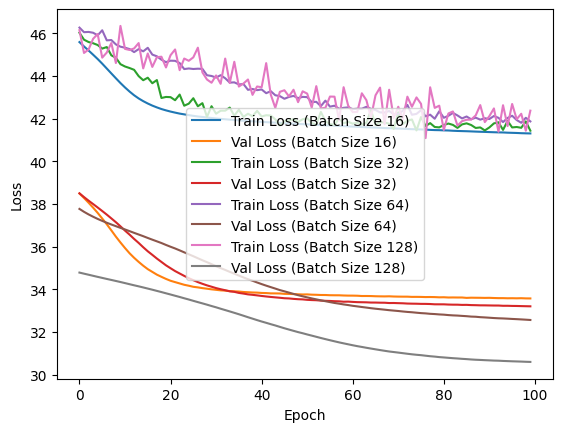

In [138]:
# Training loop with different batch sizes
batch_sizes = [16, 32, 64, 128]
num_epochs = 100

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Create data loaders for the current batch size
    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model and optimizer
    input_dim = X_train.shape[1]
    output_dim = Y_train.shape[1]
    deterministic_model = DeterministicModel(input_dim, output_dim)
    optimizer = optim.Adam(deterministic_model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    # Training loop for the current batch size
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        deterministic_model.train()
        total_train_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = deterministic_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        deterministic_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            for inputs, targets in val_loader:
                val_outputs = deterministic_model(inputs)
                val_loss = criterion(val_outputs, targets)
                total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plot the losses for the current batch size
    plt.plot(train_losses, label=f"Train Loss (Batch Size {batch_size})")
    plt.plot(val_losses, label=f"Val Loss (Batch Size {batch_size})")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [173]:
# Define the Gaussian model
class GaussianModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.mean_layer = nn.Linear(64, output_dim)
        self.log_var_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return mean, log_var

# Convert the data to PyTorch tensors
# Convert the data to PyTorch tensors
#X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
#Y_train = torch.tensor(Y_train, dtype=torch.float32).clone().detach()
#X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
#Y_val = torch.tensor(Y_val, dtype=torch.float32).clone().detach()

# Create the Gaussian model
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
gaussian_model = GaussianModel(input_dim, output_dim)

# Define loss function
def gaussian_nll_loss(y_true, mean, log_var):
    var = torch.exp(log_var)
    nll_loss = 0.5 * torch.mean(torch.log(var) + ((y_true - mean)**2) / var + torch.log(2 * torch.tensor(np.pi)))
    return nll_loss

# Define optimizer
optimizer = optim.Adam(gaussian_model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batch_size = 16

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Shuffle the data indices
    indices = torch.randperm(len(X_train))
    X_shuffled = X_train[indices]
    Y_shuffled = Y_train[indices]

    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        # Get the batch
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]

        # Forward pass
        mean, log_var = gaussian_model(X_batch)

        # Calculate loss
        loss = gaussian_nll_loss(Y_batch, mean, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / (len(X_train) // batch_size)
    train_losses.append(avg_loss)

    # Validation
    with torch.no_grad():
        val_mean, val_log_var = gaussian_model(X_val)
        val_loss = gaussian_nll_loss(Y_val, val_mean, val_log_var).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 0/20, Train Loss: 6.1053, Val Loss: 2.0237
Epoch 1/20, Train Loss: 2.2228, Val Loss: 1.9533
Epoch 2/20, Train Loss: 2.0268, Val Loss: 1.8458
Epoch 3/20, Train Loss: 1.9978, Val Loss: 1.8272
Epoch 4/20, Train Loss: 2.0800, Val Loss: 1.8682
Epoch 5/20, Train Loss: 1.9133, Val Loss: 1.7782
Epoch 6/20, Train Loss: 1.8734, Val Loss: 1.8241
Epoch 7/20, Train Loss: 1.8352, Val Loss: 1.7252
Epoch 8/20, Train Loss: 1.7513, Val Loss: 1.6808
Epoch 9/20, Train Loss: 1.7105, Val Loss: 1.6356
Epoch 10/20, Train Loss: 1.6387, Val Loss: 1.5732
Epoch 11/20, Train Loss: 1.5636, Val Loss: 1.5143
Epoch 12/20, Train Loss: 1.5227, Val Loss: 1.4915
Epoch 13/20, Train Loss: 1.4860, Val Loss: 1.4720
Epoch 14/20, Train Loss: 1.4696, Val Loss: 1.4588
Epoch 15/20, Train Loss: 1.4529, Val Loss: 1.4427
Epoch 16/20, Train Loss: 1.4367, Val Loss: 1.4275
Epoch 17/20, Train Loss: 1.4210, Val Loss: 1.4134
Epoch 18/20, Train Loss: 1.4143, Val Loss: 1.4115
Epoch 19/20, Train Loss: 1.4030, Val Loss: 1.4024


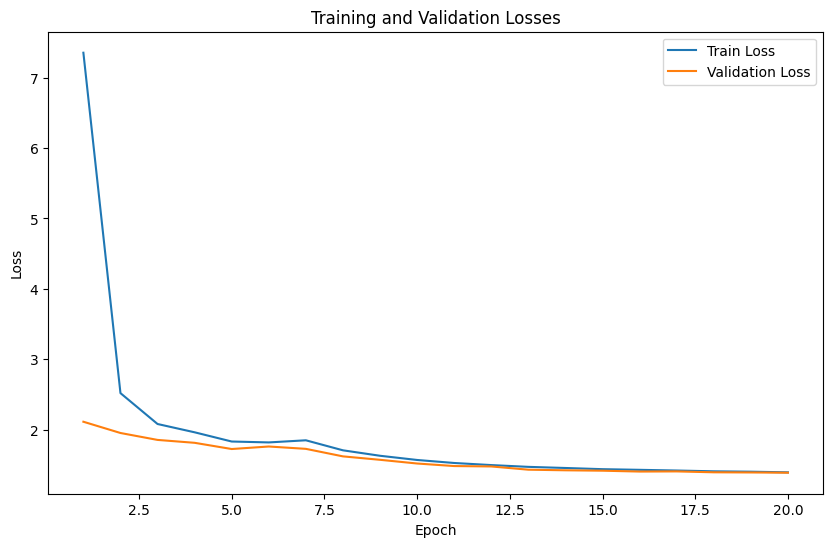

In [171]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [156]:
# Create the Gaussian model
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
gaussian_model = GaussianModel(input_dim, output_dim)

# Define loss function and optimizer
def gaussian_nll_loss(y_true, mean, log_var):
    var = np.exp(log_var)
    nll_loss = 0.5 * np.mean(np.log(var) + ((y_true - mean)**2) / var + np.log(2 * np.pi))
    return nll_loss

optimizer = optim.Adam(gaussian_model.parameters(), lr=0.001)

In [158]:
# Training loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    gaussian_model.train()
    optimizer.zero_grad()
    mean, log_var = gaussian_model(X_train)
    loss = gaussian_nll_loss(Y_train, mean, log_var)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    gaussian_model.eval()
    with torch.no_grad():
        val_mean, val_log_var = gaussian_model(X_val)
        val_loss = gaussian_nll_loss(Y_val, val_mean, val_log_var)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

TypeError: log(): argument 'input' (position 1) must be Tensor, not float

In [70]:
import torch.nn.functional as F

class GaussianModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, latent_size=10):
        super(GaussianModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        # Encoder layers
        self.fc1_enc = nn.Linear(input_size, hidden_size)
        self.fc2_enc_mean = nn.Linear(hidden_size, latent_size)
        self.fc2_enc_logvar = nn.Linear(hidden_size, latent_size)

        # Decoder layers
        self.fc1_dec = nn.Linear(latent_size, hidden_size)
        self.fc2_dec = nn.Linear(hidden_size, output_size)

    def encode(self, x):
        x = F.relu(self.fc1_enc(x))
        mean = self.fc2_enc_mean(x)
        logvar = self.fc2_enc_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def decode(self, z):
        z = F.relu(self.fc1_dec(z))
        out = self.fc2_dec(z)
        return out

    def forward(self, inputs):
        # Flatten the input tensor if needed
        inputs = inputs.view(-1, self.input_size)

        # Encode the input data to obtain the mean and log variance in the latent space
        mean, logvar = self.encode(inputs)

        # Sample from the latent space using the reparameterization trick
        z = self.reparameterize(mean, logvar)

        # Decode the samples from the latent space to obtain the output distribution
        outputs = self.decode(z)

        return outputs, mean, logvar

In [71]:
criterion_deterministic = nn.MSELoss()

import torch.nn.functional as F

def criterion_gaussian(outputs, targets, mean, logvar):
    # Compute the negative log-likelihood (NLL) loss for the Gaussian model

    # Assuming outputs have shape (batch_size, output_size)
    # and targets have shape (batch_size, output_size)
    # mean and logvar have shape (batch_size, latent_size) (from the encoder)

    # Calculate the NLL loss for each sample in the batch
    reconstruction_loss = F.mse_loss(outputs, targets, reduction='none')
    # Sum the reconstruction loss over the output dimensions
    reconstruction_loss = torch.sum(reconstruction_loss, dim=1)

    # Calculate the KL divergence loss
    kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1)

    # Total loss is the sum of reconstruction loss and KL divergence loss
    total_loss = reconstruction_loss + kl_divergence_loss

    # Return the mean loss over the batch
    return torch.mean(total_loss)

In [79]:
# Define the number of epochs for training
num_epochs = 10

# Initialize the deterministic model
deterministic_model = DeterministicModel(input_size, output_size)

# Define the optimizer for the deterministic model
optimizer_deterministic = optim.Adam(deterministic_model.parameters(), lr=0.001)

# Lists to store training and validation losses
train_losses_deterministic = []
val_losses_deterministic = []

# Training loop for the deterministic model
for epoch in range(num_epochs):
    deterministic_model.train()
    running_loss = 0.0

    # Training loop
    for data in train_loader:
        inputs = data[0]

        # Zero the gradients
        optimizer_deterministic.zero_grad()

        # Forward pass
        outputs = deterministic_model(inputs)

        # Compute the loss
        loss = criterion_deterministic(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer_deterministic.step()

        running_loss += loss.item()

    # Calculate average training loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses_deterministic.append(epoch_loss)

    # Validation loop
    deterministic_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs = data[0]
            outputs = deterministic_model(inputs)
            loss = criterion_deterministic(outputs, inputs)
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    val_loss /= len(val_loader)
    val_losses_deterministic.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")


C:\Users\jimts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 24])) that is different to the input size (torch.Size([12, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (7) must match the size of tensor b (24) at non-singleton dimension 1